new tres at 8 8
new tres at 0 4
new tres at 6 3
new tres at 4 9
mail received from agent2 with content HoldPosition_(5, 2)
mail received from agent3 with content HoldPosition_(5, 6)
mail received from agent0 with content HoldPosition_(7, 4)
mail received from agent0 with content HoldPosition_(7, 4)
mail received from agent4 with content HoldPosition_(6, 7)
mail received from agent3 with content HoldPosition_(5, 6)
departure position OK
deplacement OK
departure position OK
deplacement OK
mail received from agent1 with content Task_(8, 8)
mail received from agent2 with content HoldPosition_(5, 2)
mail received from agent0 with content Task_(6, 3)
mail received from agent4 with content HoldPosition_(6, 7)
mail received from agent0 with content HoldPosition_(6, 3)
mail received from agent4 with content HoldPosition_(6, 7)
mail received from agent1 with content HoldPosition_(8, 8)
mail received from agent3 with content HoldPosition_(5, 6)
ouverture du coffre
chest open !
ouverture du coffre

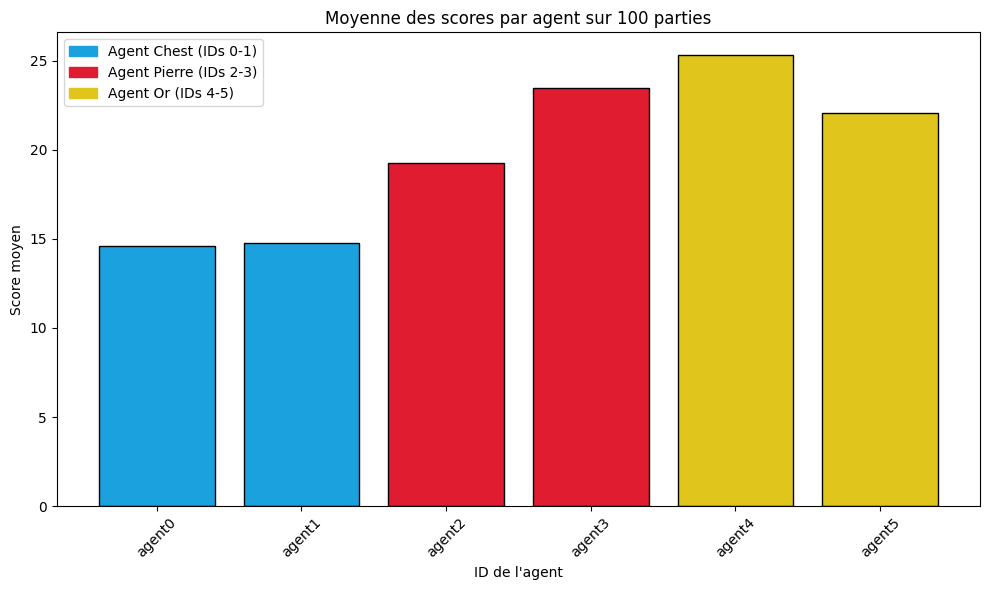

Moyenne des scores par agent sur 100 parties :
agent0: 14.59
agent1: 14.76
agent2: 19.27
agent3: 23.49
agent4: 25.33
agent5: 22.09


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.patches as mpatches

# Import des modules du projet
from Environment import Environment
from MyAgentGold import MyAgentGold
from MyAgentChest import MyAgentChest
from MyAgentStones import MyAgentStones
from Treasure import Treasure
from Graphics import Graphics

# Paramètres de la simulation
horizon = 100
num_simulations = 100

def loadFileConfig(nameFile):
    """
    Charge la configuration de l'environnement et des agents depuis un fichier.
    """
    file = open(nameFile)
    lines = file.readlines()
    tailleEnv = lines[1].split()
    tailleX = int(tailleEnv[0])
    tailleY = int(tailleEnv[1])
    zoneDepot = lines[3].split()
    cPosDepot = (int(zoneDepot[0]), int(zoneDepot[1]))
    dictAgent = {}
    env = Environment(tailleX, tailleY, cPosDepot)
    cpt = 0

    for ligne in lines[4:]:
        ligneSplit = ligne.split(":")
        if ligneSplit[0] == "tres":  # nouveau trésor
            if ligneSplit[1] == "or":
                env.addTreasure(Treasure(1, int(ligneSplit[4])), int(ligneSplit[2]), int(ligneSplit[3]))
            elif ligneSplit[1] == "pierres":
                env.addTreasure(Treasure(2, int(ligneSplit[4])), int(ligneSplit[2]), int(ligneSplit[3]))
        elif ligneSplit[0] == "AG":  # nouvel agent
            if ligneSplit[1] == "or":
                agent_id = "agent" + str(cpt)
                agent = MyAgentGold(agent_id, int(ligneSplit[2]), int(ligneSplit[3]), env, int(ligneSplit[4]))
                dictAgent[agent_id] = agent
                env.addAgent(agent)
                cpt += 1
            elif ligneSplit[1] == "pierres":
                agent_id = "agent" + str(cpt)
                agent = MyAgentStones(agent_id, int(ligneSplit[2]), int(ligneSplit[3]), env, int(ligneSplit[4]))
                dictAgent[agent_id] = agent
                env.addAgent(agent)
                cpt += 1
            elif ligneSplit[1] == "ouvr":
                agent_id = "agent" + str(cpt)
                agent = MyAgentChest(agent_id, int(ligneSplit[2]), int(ligneSplit[3]), env)
                dictAgent[agent_id] = agent
                env.addAgent(agent)
                cpt += 1

    file.close()
    env.addAgentSet(dictAgent)
    return env, dictAgent

# --- Simulation ---
# Dictionnaire pour stocker la liste des scores par agent (identifiés par leur ID)
agent_scores = {}

for sim in range(num_simulations):
    env, lAg = loadFileConfig("env1.txt")
    
    # Simulation sur 'horizon' pas de temps
    for t in range(horizon):
        if t % 10 == 0:
            env.gen_new_treasures(random.randint(0, 5), 7)
        # Chaque agent déclare son intention
        for agent in lAg.values():
            agent.broadcast_intention()
        # Résolution des conflits
        conflict_free = False
        while not conflict_free:
            for agent in lAg.values():
                agent.resolve_conflicts()
            conflict_free = all(len(agent.mailBox) == 0 for agent in lAg.values())
        # Exécution des actions
        for agent in lAg.values():
            agent.do_policy()
    
    # Enregistrement des scores individuels par agent pour cette simulation
    for agent in lAg.values():
        agent_id = agent.getId()
        score = agent.getScore()
        if agent_id not in agent_scores:
            agent_scores[agent_id] = []
        agent_scores[agent_id].append(score)

# --- Calcul de la moyenne des scores par agent ---
avg_agent_scores = {agent_id: np.mean(scores) for agent_id, scores in agent_scores.items()}

# --- Plot : Histogramme des scores moyens par agent avec couleur par type d'agent ---
plt.figure(figsize=(10, 6))
agent_ids = list(avg_agent_scores.keys())
avg_scores = [avg_agent_scores[aid] for aid in agent_ids]

# Définition des couleurs par type d'agent
colors = []
for agent_id in agent_ids:
    # Extraction du numéro (en supposant que l'ID est de la forme "agentX")
    num = int(agent_id.replace("agent", ""))
    if num in [0, 1]:
        # Agents Chest → bleu
        colors.append("#1ca1df")
    elif num in [2, 3]:
        # Agents Pierre → rouge
        colors.append("#df1c30")
    elif num in [4, 5]:
        # Agents Or → jaune
        colors.append("#dfc51c")
    else:
        colors.append("gray")

plt.bar(agent_ids, avg_scores, color=colors, edgecolor='black')
plt.xlabel("ID de l'agent")
plt.ylabel("Score moyen")
plt.title("Moyenne des scores par agent sur 100 parties")
plt.xticks(rotation=45)

# Création de la légende personnalisée
patch_chest = mpatches.Patch(color="#1ca1df", label="Agent Chest (IDs 0-1)")
patch_pierre = mpatches.Patch(color="#df1c30", label="Agent Pierre (IDs 2-3)")
patch_or = mpatches.Patch(color="#dfc51c", label="Agent Or (IDs 4-5)")
plt.legend(handles=[patch_chest, patch_pierre, patch_or])

plt.tight_layout()
plt.show()

# Affichage des moyennes par agent dans la console
print("Moyenne des scores par agent sur 100 parties :")
for agent_id, mean_score in avg_agent_scores.items():
    print(f"{agent_id}: {mean_score:.2f}")
